<a href="https://colab.research.google.com/github/Renata-Romanelli/ML_stroke_prediction/blob/main/KNN_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing K-Nearest Neighbor Classifier algorithm to classify patient in Stroke of Healthy based on results of Cerebral Autoregulaiton methods

Cerebral Autoregulaiton results (features):
- Transfer Function analysis (Gain, Phase and Coherence)
- Autoregulaiton Index - ARI
- Autoregressive Moving Average ARI - ARMA-ARI
- Mean Flow Index - nMx

In [1]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
#Load dataset
df = pd.read_csv('resultados_DOS - Acc1.csv', sep=';')
pd.set_option("display.max.columns", None)
df.head()

,Paciente,centro,Hemisferio,Status,Stroke Type,GanhoVLF,GanhoLF,GanhoHF,FaseVLF,FaseLF,FaseHF,CohVLF,CohLF,CohHF,ARI,ARI_ARMA,nMx,acceptance,Unnamed: 18
0,VOL01,BR,E,Control,Control,0.913,1.479,1.325,1.088,0.100,-0.124,0.641,0.630,0.505,6.470,5.06,0.4511,1,NaN
1,NaN,BR,D,Control,Control,0.442,1.418,1.797,0.761,0.863,0.330,0.641,0.792,0.570,7.454,5.72,0.3122,1,NaN
2,VOL02,BR,E,Control,Control,0.627,1.788,1.451,0.937,1.071,-0.223,0.209,0.772,0.658,7.960,7.11,0.1172,1,NaN
3,NaN,BR,D,Control,Control,0.787,2.228,1.835,0.937,1.070,-0.206,0.484,0.770,0.657,7.950,7.48,0.0140,1,NaN
4,VOL03,BR,E,Control,Control,0.719,1.031,1.326,0.392,0.760,-0.097,0.492,0.565,0.754,3.971,3.17,0.5492,1,NaN


In [3]:
#Display dataset columns
df.columns

Index(['Paciente', 'centro', 'Hemisferio', 'Status', 'Stroke Type', 'GanhoVLF',
       'GanhoLF', 'GanhoHF', 'FaseVLF', 'FaseLF', 'FaseHF', 'CohVLF', 'CohLF',
       'CohHF', 'ARI', 'ARI_ARMA', 'nMx', 'acceptance', 'Unnamed: 18'],
      dtype='object')

In [4]:
df.drop(['Paciente', 'centro', 'Hemisferio', 'acceptance', 'Unnamed: 18'], inplace=True, axis=1)

In [5]:
cols = {'Stroke Type':'Hemisphere'}

df.rename(cols, inplace=True, axis=1)
df.shape

(158, 14)

In [6]:
df_encoded = pd.get_dummies(data=df, columns=['Status'])
df_encoded = pd.get_dummies(data=df_encoded, columns=['Hemisphere'])
df_encoded.head()

,GanhoVLF,GanhoLF,GanhoHF,FaseVLF,FaseLF,FaseHF,CohVLF,CohLF,CohHF,ARI,ARI_ARMA,nMx,Status_Affected,Status_Control,Status_Unnafected,Hemisphere_Control,Hemisphere_Unnafected,Hemisphere_mild,Hemisphere_moderate,Hemisphere_severe
0,0.913,1.479,1.325,1.088,0.100,-0.124,0.641,0.630,0.505,6.470,5.06,0.4511,0,1,0,1,0,0,0,0
1,0.442,1.418,1.797,0.761,0.863,0.330,0.641,0.792,0.570,7.454,5.72,0.3122,0,1,0,1,0,0,0,0
2,0.627,1.788,1.451,0.937,1.071,-0.223,0.209,0.772,0.658,7.960,7.11,0.1172,0,1,0,1,0,0,0,0
3,0.787,2.228,1.835,0.937,1.070,-0.206,0.484,0.770,0.657,7.950,7.48,0.0140,0,1,0,1,0,0,0,0
4,0.719,1.031,1.326,0.392,0.760,-0.097,0.492,0.565,0.754,3.971,3.17,0.5492,0,1,0,1,0,0,0,0


Target Variables:

**Status_Affected**: Defines 1 for AIS participant with affected hemisphere

**Status_Control**: Defines 1 as control participant and 0 for AIS participant  (main target)

**Status_Unnafected**: Defines 1 for AIS participant with unaffected hemisphere

## Balancing data

In [69]:
import seaborn as sns

0    51.265823
1    48.734177
Name: Status_Control, dtype: float64


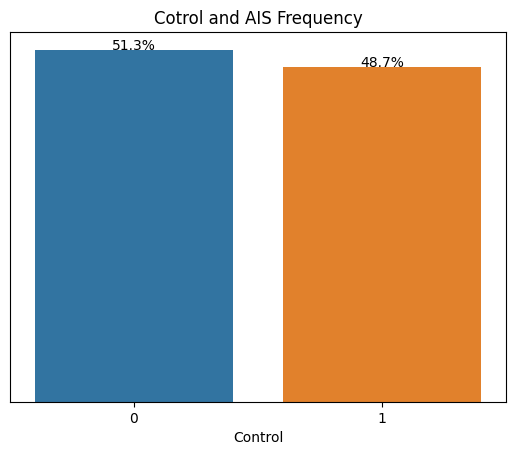

In [71]:
Control_frequency = df_encoded.Status_Control.value_counts(normalize=True)*100
print(Control_frequency)

fig1 = sns.barplot(x=Control_frequency.index, y=Control_frequency.values)
fig1.set_ylabel('(%)')
fig1.set_xlabel('Control')
fig1.set_title('Cotrol and AIS Frequency')
fig1.axes.get_yaxis().set_visible(False)

percentage = [Control_frequency[0], Control_frequency[1]]
patches = fig1.patches
for bar in range(len(patches)):
  x = patches[bar].get_x() + patches[bar].get_width()/2
  y = patches[bar].get_height() + .05
  fig1.annotate('{:.1f}%'.format(percentage[bar]), (x,y), ha='center')

Data is already balanced

## Remove outliers and visualize data

In [7]:
def removeoutlier(values):
  values = values.copy()
  fator = 1.5
  q3, q1 = np.percentile(values, [75, 25])
  iqr = q3 - q1
  lowpass = q1 - (iqr*fator)
  highpass = q3 + (iqr*fator)

  values[(values < lowpass) + (values > highpass)] = values.median()

  return values

In [10]:
df.GanhoVLF = removeoutlier(df.GanhoVLF)
df.GanhoLF = removeoutlier(df.GanhoLF)
df.GanhoHF = removeoutlier(df.GanhoHF)
df.FaseVLF = removeoutlier(df.FaseVLF)
df.FaseLF = removeoutlier(df.FaseLF)
df.FaseHF = removeoutlier(df.FaseHF)
df.ARI = removeoutlier(df.ARI)
df.ARI_ARMA = removeoutlier(df.ARI_ARMA)
df.nMx = removeoutlier(df.nMx)

Text(0.5, 1.0, '')

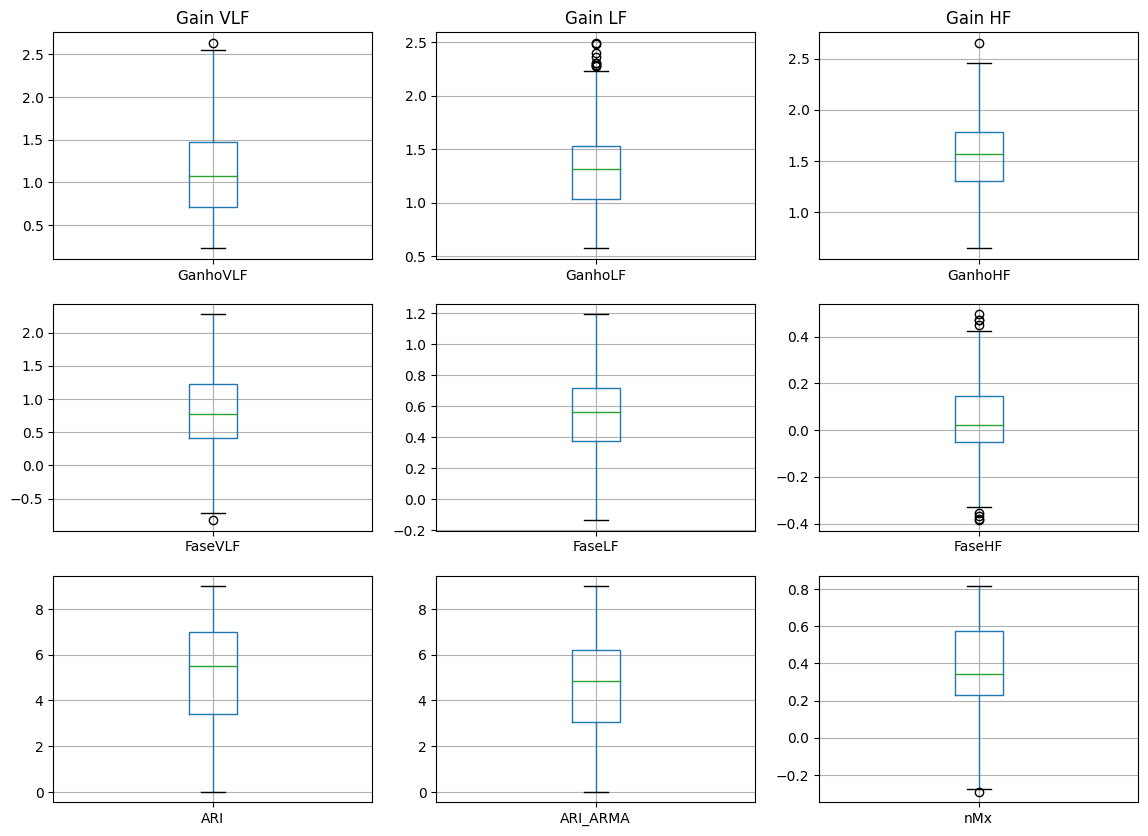

In [11]:
# draw boxplots to visualize outliers

plt.figure(figsize=(14,10))

plt.subplot(3, 3, 1)
fig = df.boxplot(column='GanhoVLF')
fig.set_title('Gain VLF')

plt.subplot(3, 3, 2)
fig = df.boxplot(column='GanhoLF')
fig.set_title('Gain LF')

plt.subplot(3, 3, 3)
fig = df.boxplot(column='GanhoHF')
fig.set_title('Gain HF')

plt.subplot(3, 3, 4)
fig = df.boxplot(column='FaseVLF')
fig.set_title('')

plt.subplot(3, 3, 5)
fig = df.boxplot(column='FaseLF')
fig.set_title('')

plt.subplot(3, 3, 6)
fig = df.boxplot(column='FaseHF')
fig.set_title('')

plt.subplot(3, 3, 7)
fig = df.boxplot(column='ARI')
fig.set_title('')

plt.subplot(3, 3, 8)
fig = df.boxplot(column='ARI_ARMA')
fig.set_title('')

plt.subplot(3, 3, 9)
fig = df.boxplot(column='nMx')
fig.set_title('')

## Functions with the evaluation metrics

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

def ROC_curve(y_test, y_pred):

  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  # print('AUC: {}'.format(round(roc_auc,2)))

  plt.title('title')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right', fontsize=17)
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True positive', fontsize=15)
  plt.xlabel('True negative', fontsize=15)
  plt.show()
  return roc_auc

In [67]:
from sklearn.metrics import confusion_matrix

def ConfMat(y_test, y_pred):
  conf_matrix = confusion_matrix(y_test, y_pred)

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.matshow(conf_matrix, cmap='viridis', alpha=0.8)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

  plt.xlabel('True Class', fontsize=18)
  plt.ylabel('Predicted Class', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

# K Nearest Neighbors (KNN)

In [37]:
#Collect all independent data features into the X data-frame and target field into a y data-frame
data_Knn = df_encoded[['ARI', 'Status_Control']]
X = data_Knn.drop(['Status_Control'], axis = 1)
y = data_Knn['Status_Control']

In [38]:
#Manipulate the data and normalize it
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

In [39]:
# Importing cross-validation and KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

k = 4
neigh = KNeighborsClassifier(n_neighbors=k)

# Performing cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(neigh, X, y, cv=cv)

print("Accuracy of model at K=4 using cross-validation: {:.2f}".format(scores.mean()))

Accuracy of model at K=4 using cross-validation: 0.51


No código sugerido, cada fold é usado como conjunto de teste uma vez, enquanto o restante dos folds são combinados para formar o conjunto de treinamento. Nesse caso, como especificado em cv = KFold(n_splits=5, shuffle=True, random_state=42), estamos usando a validação cruzada com 5 folds. Isso significa que o conjunto de dados será dividido em 5 partes iguais (ou quase iguais, se o número de amostras não for divisível por 5).

Em cada iteração da validação cruzada, um dos folds será usado como conjunto de teste e os outros 4 folds serão combinados para formar o conjunto de treinamento. O modelo será treinado com o conjunto de treinamento e avaliado com o conjunto de teste. Esse processo será repetido 5 vezes, de forma que cada fold seja utilizado como conjunto de teste uma vez.

Assim, em cada fold, aproximadamente 80% dos dados serão usados para treinamento (4 folds) e aproximadamente 20% dos dados serão usados para teste (1 fold).

Caso deseje ajustar o número de folds, você pode modificar o parâmetro n_splits em KFold(n_splits=5, shuffle=True, random_state=42) para o valor desejado.

Maximum Accuracy: 0.607 at K = 20


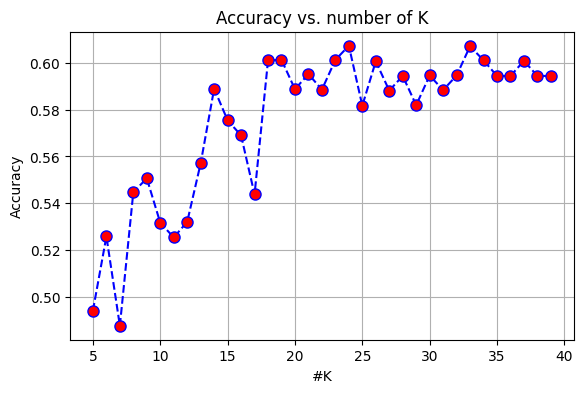

In [40]:
from sklearn import metrics

# List to store the accuracies
acc = []

# K values to be tested
k_values = range(5, 40)

# Loop to test different K values
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(neigh, X, y, cv=5)  # Using cross-validation with 5 folds
    acc.append(scores.mean())

# Plotting the accuracy curve
plt.figure(figsize=(6.5, 4))
plt.plot(k_values, acc, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Accuracy vs. number of K')
plt.xlabel('#K')
plt.ylabel('Accuracy')
plt.grid()

# Finding the maximum accuracy and the corresponding K
max_acc = np.round(max(acc), 3)
optimal_k = acc.index(max(acc)) + 1
print("Maximum Accuracy:", max_acc, "at K =", optimal_k)

In [41]:
# Define the classifier with the optimal K value
optimal_k = acc.index(max(acc)) + 1
neigh = KNeighborsClassifier(n_neighbors=optimal_k)
neigh.fit(X, y)

# Make predictions
y_pred = neigh.predict(X)

# Get scores
cv_scores = cross_val_score(neigh, X, y, cv=5)
scores = cross_val_score(neigh, X, y, cv=5)

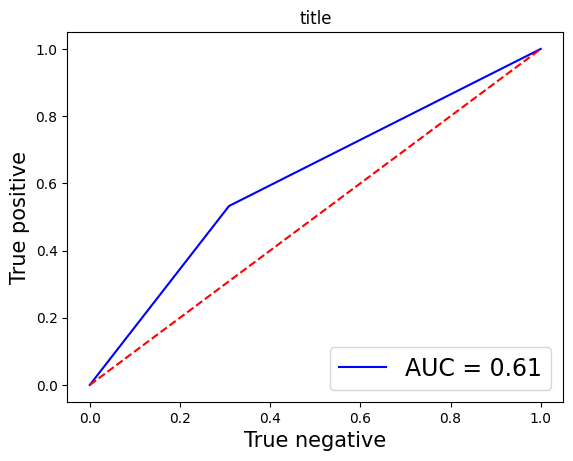

In [42]:
roc_auc = ROC_curve(y, y_pred)

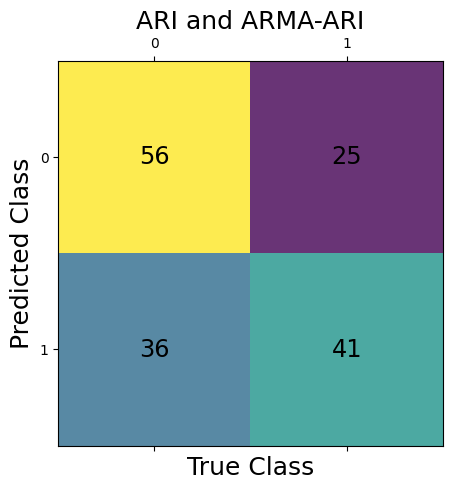

In [43]:
ConfMat(y, y_pred)

## Using K-NN with Manhattan distance

In [60]:
#Collect all independent data features into the X data-frame and target field into a y data-frame
data_Knn_Manhattan = df_encoded[['nMx', 'Status_Control']]
Xm = data_Knn_Manhattan.drop(['Status_Control'], axis = 1)
ym = data_Knn_Manhattan['Status_Control']

In [61]:
Xm = preprocessing.StandardScaler().fit(Xm).transform(Xm.astype(float))

In [62]:
k = 4
neigh = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='distance')

# Performing cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores_Manh = cross_val_score(neigh, Xm, ym, cv=cv)

print("Accuracy of model at K=4 using Manhattan distance: {:.2f}".format(scores_Manh.mean()))

Accuracy of model at K=4 using Manhattan distance: 0.58


In [63]:
from sklearn import metrics

# List to store the accuracies
acc_m = []

# K values to be tested
k_values = range(5, 40)

# Loop to test different K values
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='distance')
    scores_Manh = cross_val_score(neigh, Xm, ym, cv=5)  # Using cross-validation with 5 folds
    acc_m.append(scores_Manh.mean())

# Finding the maximum accuracy and the corresponding K
max_acc = np.round(max(acc_m), 3)
optimal_k = acc_m.index(max(acc_m)) + 1
print("Maximum Accuracy:", max_acc, "at K =", optimal_k)

Maximum Accuracy: 0.608 at K = 4


In [64]:
# Define the classifier with the optimal K value
optimal_k = acc_m.index(max(acc_m)) + 1
neigh = KNeighborsClassifier(n_neighbors=optimal_k, metric='manhattan', weights='distance')
neigh.fit(Xm, ym)

# Make predictions
y_pred_Manh = neigh.predict(Xm)

# Get scores
cv_scores = cross_val_score(neigh, Xm, ym, cv=5)
scores = cross_val_score(neigh, Xm, ym, cv=5)

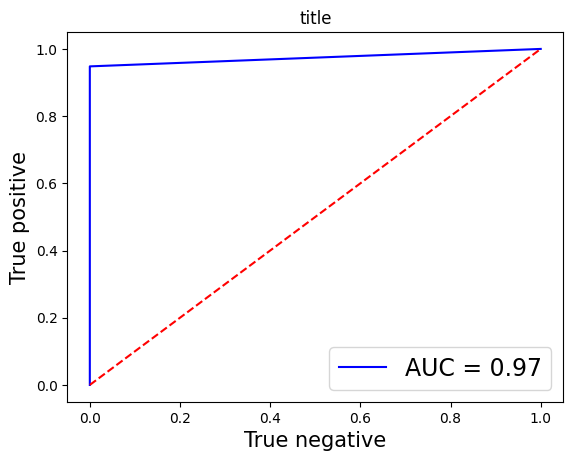

In [65]:
roc_auc = ROC_curve(ym, y_pred)

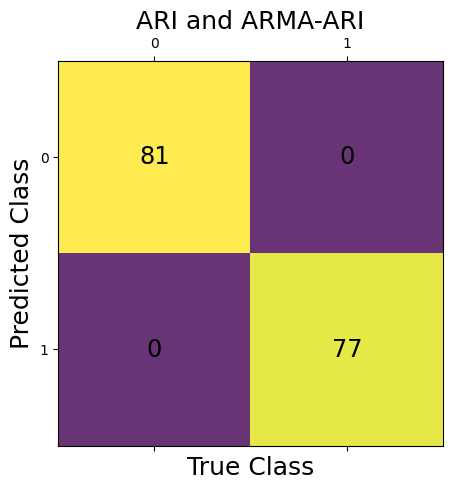

In [66]:
ConfMat(y, y_pred_Manh)